In [1]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1000)
T_vals = (600, 700, 800, 900, 1000)
P_vals = (0.1, 1, 10, 100)
T_drop = (300,)  # Drop 300 K rates for fit
A_fill = 1e-20

stoich = "C5H7"
stoich = "C5H9"
stoich = "C5H9O"
# stoich = "C5H9O2"
# stoich = "C5H11O"
clear_labels = []
# stoich = "C5H7O2"
# clear_labels = ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [2]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [3]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [4]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [5]:
clear_keys = [mess.surf.node_key_from_label(surf_out, label) for label in clear_labels]

print(f"Clearing out rates for nodes {clear_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_keys)

Clearing out rates for nodes []


In [6]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[]


In [7]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(0, 3), (0, 4), (0, 5), (0, 10), (0, 11), (1, 2), (1, 5), (1, 9), (1, 10), (2, 1), (2, 4), (2, 9), (2, 10), (3, 0), (3, 4), (3, 5), (3, 9), (3, 11), (3, 13), (4, 0), (4, 2), (4, 3), (4, 5), (4, 11), (4, 13), (5, 0), (5, 1), (5, 3), (5, 4), (5, 11), (5, 13), (9, 1), (9, 2), (9, 3), (9, 11), (9, 13), (10, 0), (10, 1), (10, 2), (10, 11), (10, 13), (11, 0), (11, 3), (11, 4), (11, 5), (11, 9), (11, 10), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 9), (13, 10), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 9), (15, 10), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 9), (17, 10)]


In [8]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [9]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[]


In [10]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [11]:
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

In [12]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [13]:
print("Clearing unfittable pressures.")
surf_out = mess.surf.clear_unfittable_pressures(surf_out)

Clearing unfittable pressures.


In [14]:
surf_out = mess.surf.fit_rates(surf_out, T_drop=T_drop, A_fill=A_fill)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=2746172440.164306 b=1.254624388143152 E=31710.34140998592 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=14032142296.812126 b=1.0158636274394235 E=35803.78173196155 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=862443861.4057515 b=1.3579328870772565 E=32736.137594016192 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)


Direct rates:
(0, 9) C5H9O(853)e = C2H4(52) + C3H5O(168)e


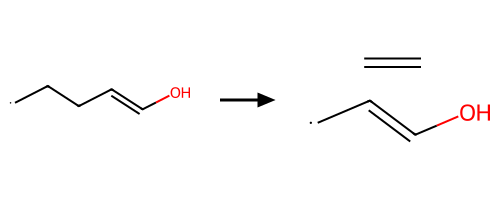

alt.LayerChart(...)

Median branching fraction: 0.29811060634696523 (reverse direction)
[[0.28255814 0.29823524 0.29798598 0.29796513]
 [0.25385406 0.30734292 0.30950275 0.30885844]
 [0.18524775 0.29770992 0.31499693 0.31331747]
 [0.11132623 0.26134056 0.31660984 0.31519766]
 [0.0571319  0.19668737 0.30522088 0.31607263]]

(1, 0) C5H9O(852)r0 = C5H9O(853)e


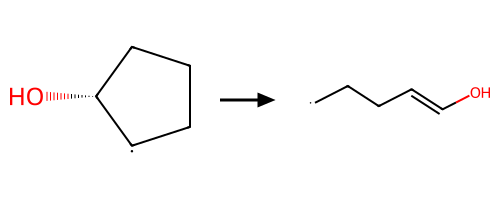

alt.LayerChart(...)

Median branching fraction: 0.0009090836295705593
[[0.00624365 0.00065836 0.00031233 0.00029584]
 [0.00347013 0.00097074 0.00055558 0.00057239]
 [0.0011617  0.00098919 0.000805   0.00090908]
 [0.00048188 0.00084926 0.00099918 0.00125375]
 [       nan 0.00065813 0.00110158 0.00156201]]

(1, 3) C5H9O(852)r0 = C5H9O(853)z


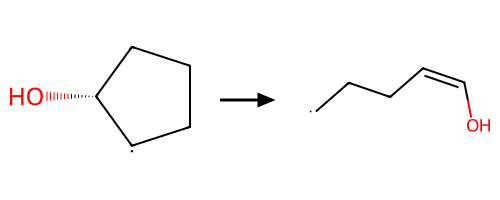

alt.LayerChart(...)

Median branching fraction: 2.9778334989211136e-05
[[5.68570688e-05 1.27877220e-05 9.20097780e-06 1.02175659e-05]
 [4.15452080e-05 2.46450743e-05 2.27849409e-05 2.96738721e-05]
 [1.69736849e-05 3.03083335e-05 4.08735189e-05 6.21756679e-05]
 [8.24337274e-06 2.97783350e-05 5.87194472e-05 1.03200099e-04]
 [           nan 2.56152731e-05 7.21773473e-05 1.46982407e-04]]

(1, 4) C5H9O(852)r0 = C5H9O(878)r0


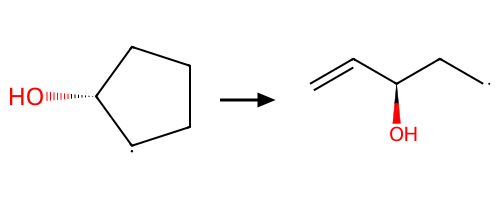

alt.LayerChart(...)

Median branching fraction: 0.00022653092795780818
[[1.11854327e-03 1.44037528e-04 7.63090269e-05 7.53284830e-05]
 [6.56433565e-04 2.26366472e-04 1.49818789e-04 1.64687480e-04]
 [2.26530928e-04 2.37520716e-04 2.28354401e-04 2.85442839e-04]
 [9.51045496e-05 2.02377034e-04 2.88861797e-04 4.15359075e-04]
 [           nan 1.59481018e-04 3.17063065e-04 5.32356775e-04]]

(2, 0) C5H9O(852)r1 = C5H9O(853)e


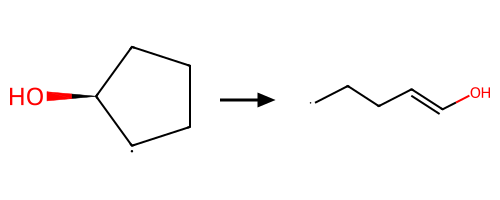

alt.LayerChart(...)

Median branching fraction: 0.0009090836295705593
[[0.00624365 0.00065836 0.00031233 0.00029584]
 [0.00347013 0.00097074 0.00055558 0.00057239]
 [0.0011617  0.00098919 0.000805   0.00090908]
 [0.00048188 0.00084926 0.00099918 0.00125375]
 [       nan 0.00065813 0.00110158 0.00156201]]

(2, 3) C5H9O(852)r1 = C5H9O(853)z


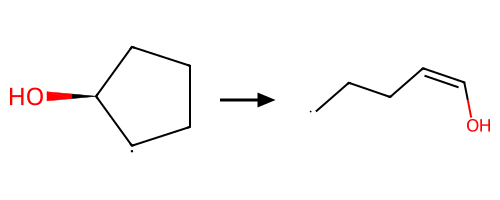

alt.LayerChart(...)

Median branching fraction: 2.9778334989211136e-05
[[5.68570688e-05 1.27877220e-05 9.20097780e-06 1.02175659e-05]
 [4.15452080e-05 2.46450743e-05 2.27849409e-05 2.96738721e-05]
 [1.69736849e-05 3.03083335e-05 4.08735189e-05 6.21756679e-05]
 [8.24337274e-06 2.97783350e-05 5.87194472e-05 1.03200099e-04]
 [           nan 2.56152731e-05 7.21773473e-05 1.46982407e-04]]

(2, 5) C5H9O(852)r1 = C5H9O(878)r1


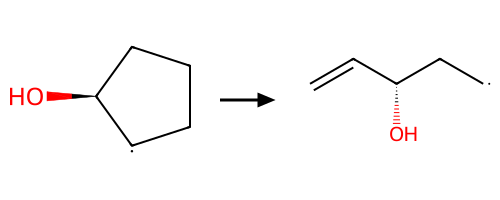

alt.LayerChart(...)

Median branching fraction: 0.00022653092795780818
[[1.11854327e-03 1.44037528e-04 7.63090269e-05 7.53284830e-05]
 [6.56433565e-04 2.26366472e-04 1.49818789e-04 1.64687480e-04]
 [2.26530928e-04 2.37520716e-04 2.28354401e-04 2.85442839e-04]
 [9.51045496e-05 2.02377034e-04 2.88861797e-04 4.15359075e-04]
 [           nan 1.59481018e-04 3.17063065e-04 5.32356775e-04]]

(3, 10) C5H9O(853)z = C2H4(52) + C3H5O(168)z


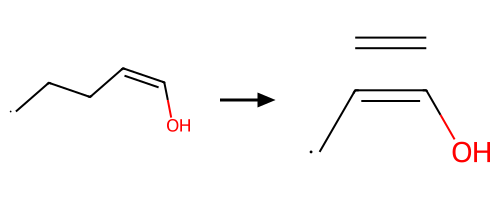

alt.LayerChart(...)

Median branching fraction: 0.26653696498054474 (reverse direction)
[[0.31050457 0.2999788  0.29550404 0.29450338]
 [0.27642276 0.28529194 0.27766759 0.27467521]
 [0.20658524 0.26970228 0.26653696 0.25991864]
 [0.12624411 0.23606168 0.25854879 0.24916326]
 [       nan 0.17804154 0.24801587 0.24242424]]

(4, 9) C5H9O(878)r0 = C2H4(52) + C3H5O(168)e


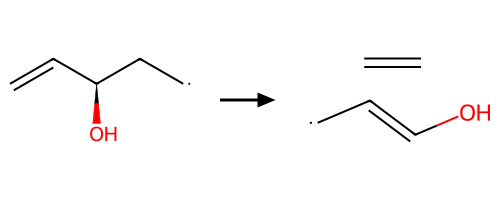

alt.LayerChart(...)

Median branching fraction: 0.2883131172649332 (reverse direction)
[[0.28139535 0.3347136  0.34891968 0.3507992 ]
 [0.19732785 0.29523089 0.33671179 0.3445997 ]
 [0.11317568 0.23473282 0.3165335  0.3399199 ]
 [0.05421104 0.16249154 0.28007793 0.3324627 ]
 [0.0247316  0.09997042 0.22891566 0.31775387]]

(4, 10) C5H9O(878)r0 = C2H4(52) + C3H5O(168)z


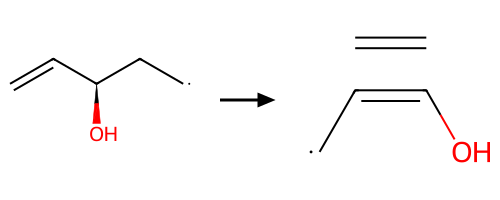

alt.LayerChart(...)

Median branching fraction: 0.3157983956820386 (reverse direction)
[[0.28796795 0.33813865 0.35071933 0.35258883]
 [0.2195122  0.31633407 0.35435674 0.36189435]
 [0.1354222  0.26444834 0.34463591 0.3671615 ]
 [0.0684477  0.19217082 0.31526272 0.36667906]
 [0.03202777 0.12166172 0.26488095 0.35666398]]

(5, 9) C5H9O(878)r1 = C2H4(52) + C3H5O(168)e


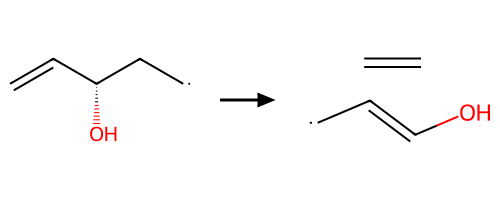

alt.LayerChart(...)

Median branching fraction: 0.2883131172649332 (reverse direction)
[[0.28139535 0.3347136  0.34891968 0.3507992 ]
 [0.19732785 0.29523089 0.33671179 0.3445997 ]
 [0.11317568 0.23473282 0.3165335  0.3399199 ]
 [0.05421104 0.16249154 0.28007793 0.3324627 ]
 [0.0247316  0.09997042 0.22891566 0.31775387]]

(5, 10) C5H9O(878)r1 = C2H4(52) + C3H5O(168)z


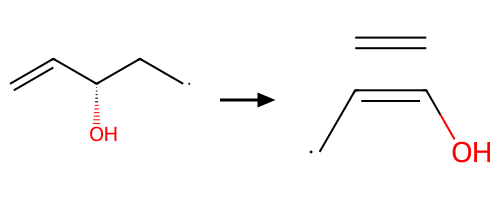

alt.LayerChart(...)

Median branching fraction: 0.3157983956820386 (reverse direction)
[[0.28796795 0.33813865 0.35071933 0.35258883]
 [0.2195122  0.31633407 0.35435674 0.36189435]
 [0.1354222  0.26444834 0.34463591 0.3671615 ]
 [0.0684477  0.19217082 0.31526272 0.36667906]
 [0.03202777 0.12166172 0.26488095 0.35666398]]

(11, 1) C5H8(522) + OH(4) = C5H9O(852)r0


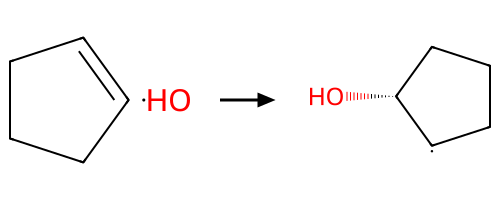

alt.LayerChart(...)

Median branching fraction: 0.00021937857991328119
[[3.78985831e-05 1.27374389e-04 2.19378580e-04 2.70268521e-04]
 [2.06401878e-05 1.30702031e-04 3.72373087e-04 6.05780671e-04]
 [8.90408051e-06 9.42911341e-05 4.54643010e-04 1.07130448e-03]
 [3.33039001e-06 5.03233619e-05 3.89297691e-04 1.42539640e-03]
 [           nan 1.88445958e-05 2.38015606e-04 1.42585875e-03]]

(11, 2) C5H8(522) + OH(4) = C5H9O(852)r1


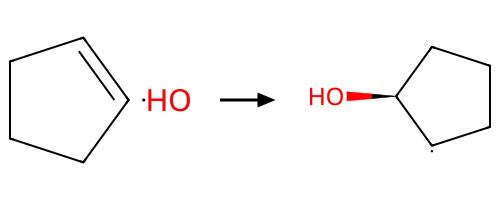

alt.LayerChart(...)

Median branching fraction: 0.00021937857991328119
[[3.78985831e-05 1.27374389e-04 2.19378580e-04 2.70268521e-04]
 [2.06401878e-05 1.30702031e-04 3.72373087e-04 6.05780671e-04]
 [8.90408051e-06 9.42911341e-05 4.54643010e-04 1.07130448e-03]
 [3.33039001e-06 5.03233619e-05 3.89297691e-04 1.42539640e-03]
 [           nan 1.88445958e-05 2.38015606e-04 1.42585875e-03]]

(11, 13) C5H8(522) + OH(4) = C5H7(1202) + H2O(5)


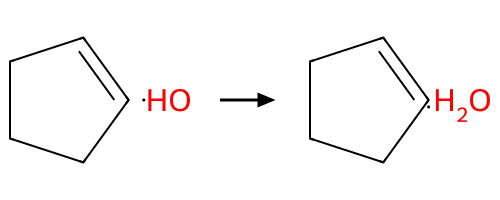

alt.LayerChart(...)

Median branching fraction: 0.026466543511706977
[[0.01815143 0.01553173 0.0140894  0.01386947]
 [0.02286001 0.0208525  0.0194965  0.01926165]
 [0.02820922 0.02695748 0.02597561 0.02576922]
 [0.03398982 0.03342491 0.03297789 0.03282731]
 [0.04021734 0.04043669 0.04061654 0.04056381]]

(11, 15) C5H8(522) + OH(4) = C5H7(500) + H2O(5)


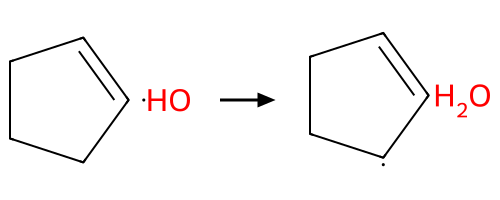

alt.LayerChart(...)

Median branching fraction: 0.7285458665381325
[[0.74600369 0.75444951 0.75844565 0.75934126]
 [0.73603689 0.74095293 0.74335538 0.74362298]
 [0.72537556 0.72841166 0.72910134 0.72868008]
 [0.71555818 0.71639542 0.71678288 0.7154469 ]
 [0.70470876 0.70501192 0.70408812 0.70238006]]

(11, 17) C5H8(522) + OH(4) = C5H7(504) + H2O(5)


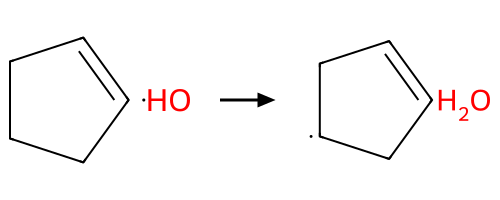

alt.LayerChart(...)

Median branching fraction: 0.24422802189814702
[[0.23576908 0.22976401 0.22702619 0.22624874]
 [0.24106182 0.23793317 0.23640337 0.23590381]
 [0.24639741 0.24444228 0.24401376 0.2434081 ]
 [0.25044535 0.25007902 0.24946063 0.248875  ]
 [0.2550739  0.2545137  0.2548193  0.25420441]]



In [15]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    # if amchis:
    #     ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
    #     ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    key1, key2 = rate_key
    rev_rate_key = (key2, key1)
    min_rate_key = min(
        rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])
    )
    branch_frac_arr = branch_frac_dct[min_rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    if rate_key == min_rate_key:
        print(f"Median branching fraction: {branch_frac}")
    else:
        print(f"Median branching fraction: {branch_frac} (reverse direction)")

    print(branch_frac_arr)
    print()

In [16]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )
    key1, key2 = rate_key
    rev_rate_key = (key2, key1)
    min_rate_key = min(
        rate_key, rev_rate_key, key=lambda k: np.nanmedian(branch_frac_dct[k])
    )
    branch_frac_arr = branch_frac_dct[min_rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    if rate_key == min_rate_key:
        print(f"Median branching fraction: {branch_frac}")
    else:
        print(f"Median branching fraction: {branch_frac} (reverse direction)")

    print(branch_frac_arr)
    print()

Well-skipping rates:
(9, 10)


alt.LayerChart(...)

Median branching fraction: 0.0964828413922171 (reverse direction)
[[1.13559534e-01 2.37439050e-02 3.05729097e-03 3.18960413e-04]
 [2.84552846e-01 8.20399113e-02 1.36189343e-02 1.53609831e-03]
 [5.22570366e-01 2.01401051e-01 4.41912173e-02 5.75836019e-03]
 [7.36860485e-01 3.79596679e-01 1.10925771e-01 1.74786166e-02]
 [8.71102960e-01 5.78635015e-01 2.22222222e-01 4.42477876e-02]]

(13, 15)


alt.LayerChart(...)

Median branching fraction: 0.005200253874260749 (reverse direction)
[[8.07727404e-03 3.24380206e-03 5.19382844e-04 3.16793898e-05]
 [1.41683196e-02 6.60805794e-03 1.24438856e-03 8.23412022e-05]
 [2.13210727e-02 1.10140407e-02 2.39439098e-03 1.70648533e-04]
 [2.99978347e-02 1.66995050e-02 4.17679107e-03 3.18808575e-04]
 [3.80102224e-02 2.22985528e-02 6.22371668e-03 5.10297543e-04]]

(13, 17)


alt.LayerChart(...)

Median branching fraction: 0.004945560438121905 (reverse direction)
[[5.59313544e-03 3.06348111e-03 5.77630423e-04 3.76598137e-05]
 [9.56093256e-03 5.87850733e-03 1.34011670e-03 9.63020094e-05]
 [1.43137340e-02 9.45533872e-03 2.52505376e-03 1.98012758e-04]
 [1.99797389e-02 1.39601045e-02 4.29798543e-03 3.67401924e-04]
 [2.57869628e-02 1.84037363e-02 6.35945602e-03 5.89943204e-04]]

(15, 17)


alt.LayerChart(...)

Median branching fraction: 0.06458880955578046
[[0.24231822 0.08422855 0.01304496 0.00111147]
 [0.27166778 0.1119853  0.02042811 0.00183267]
 [0.28586913 0.13304961 0.02803025 0.00264688]
 [0.30473152 0.15498102 0.03749966 0.00372065]
 [0.30451371 0.16554986 0.04494906 0.00472614]]

